# **Data context**

A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations.

The dataset consists of 202599 face images of various celebrities. There are 10177 unique identities (names of identities are not given). Each image has 40 binary attribure annotations and there are 5 landmark locations.

*(source: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)*


# **Data content**

There are 5 data files with content as below:

*   **img_align_celeba.zip**: All the face images, cropped and aligned

*   **list_eval_partition.csv**: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
*   **list_bbox_celeba.csv**: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box

*   **list_landmarks_align_celeba.csv**: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
*   **list_attr_celeba.csv**: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

*(source: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)*

# **Imports**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import tqdm
import random
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import transform
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import zipfile
from skimage import io
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.layer_utils import count_params
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import tensorflow as tf
from keras import regularizers
from google.colab import files

from joblib import dump, load

warnings.filterwarnings('ignore')

# **Data preparation**

# Download data

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
%%capture
!kaggle datasets download -d jessicali9530/celeba-dataset

# Unzip dataset

In [ ]:
%%capture
!unzip celeba-dataset.zip

# Create dataframe for input and output

In [ ]:
input_path = []
label = []

for class_name in os.listdir("img_align_celeba"):
    for path in os.listdir("img_align_celeba/"+class_name):
      input_path.append(os.path.join(path))
print(input_path[0])

096360.jpg


# **EDA**

In [ ]:
# All ids of images
df = pd.DataFrame()
df['image_id'] = input_path
df.head()

,image_id
0,096360.jpg
1,049624.jpg
2,096613.jpg
3,163774.jpg
4,199975.jpg


In [ ]:
# Amount of photos
print(len(df))

202599


In [ ]:
# Frame with attributes
attr = pd.DataFrame()
attr = pd.read_csv('list_attr_celeba.csv')
attr

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1


In [ ]:
# Frame with images sizes
bbox = pd.DataFrame()
bbox = pd.read_csv('list_bbox_celeba.csv')
bbox

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166
...,...,...,...,...,...
202594,202595.jpg,1381,91,221,306
202595,202596.jpg,137,129,114,158
202596,202597.jpg,53,76,91,126
202597,202598.jpg,195,28,91,126


In [ ]:
# Frame with partition to train, test and validation set
eval = pd.DataFrame()
eval = pd.read_csv('list_eval_partition.csv')
eval

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,2
202595,202596.jpg,2
202596,202597.jpg,2
202597,202598.jpg,2


In [ ]:
# Frame with images details
land = pd.DataFrame()
land = pd.read_csv('list_landmarks_align_celeba.csv')
land

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150
...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,69,111,108,111,89,140,73,151,104,153
202595,202596.jpg,67,112,110,112,85,141,66,150,110,150
202596,202597.jpg,69,111,107,111,92,137,68,151,109,153
202597,202598.jpg,69,111,108,111,90,137,71,153,106,151


In [ ]:
# Frame with partition and male
df_all = pd.merge(attr, eval, on="image_id")
df = df_all[['image_id', 'Male', 'partition']]
df

,image_id,Male,partition
0,000001.jpg,-1,0
1,000002.jpg,-1,0
2,000003.jpg,1,0
3,000004.jpg,-1,0
4,000005.jpg,-1,0
...,...,...,...
202594,202595.jpg,-1,2
202595,202596.jpg,1,2
202596,202597.jpg,1,2
202597,202598.jpg,-1,2


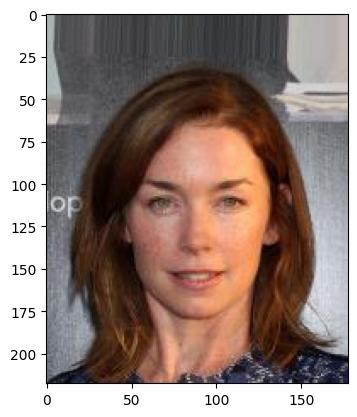

In [ ]:
# Example of photo
img = mpimg.imread('img_align_celeba/img_align_celeba/197683.jpg')
imgplt = plt.imshow(img)
plt.show()

In [ ]:
# Image size
img.shape

(218, 178, 3)

In [ ]:
# Train, test, validation split
df_train_pre = df[df['partition'] == 0]
df_val_pre = df[df['partition'] == 1]
df_test_pre = df[df['partition']== 2]

df_train = df_train_pre[['image_id', 'Male']]
df_val = df_val_pre[['image_id', 'Male']]
df_test = df_test_pre[['image_id', 'Male']]
df_test

,image_id,Male
182637,182638.jpg,-1
182638,182639.jpg,-1
182639,182640.jpg,-1
182640,182641.jpg,-1
182641,182642.jpg,-1
...,...,...
202594,202595.jpg,-1
202595,202596.jpg,1
202596,202597.jpg,1
202597,202598.jpg,-1


<Axes: >

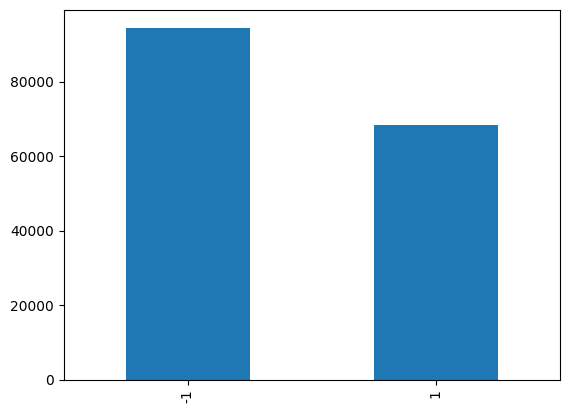

In [ ]:
# Train balance
df_train['Male'].value_counts().plot.bar()

<Axes: >

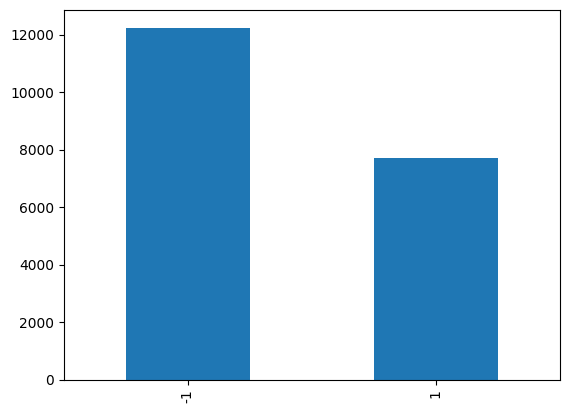

In [ ]:
# Test balance
df_test['Male'].value_counts().plot.bar()

<Axes: >

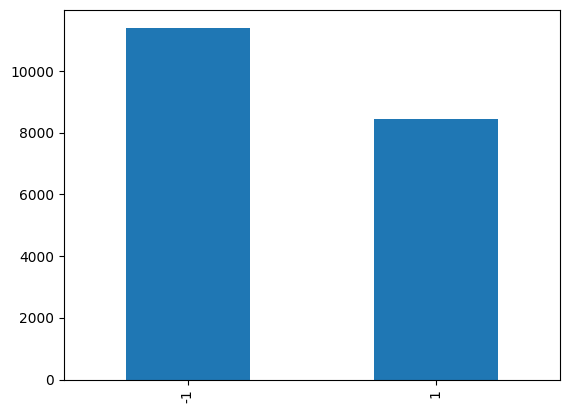

In [ ]:
# Validation balance
df_val['Male'].value_counts().plot.bar()

All sets all well balanced. The diffenece in male and female amounts is related to overall lower amount of males in sets.

# **Iterators and genarators for each set**

In [ ]:
# Change the type of Male column to str
df_train['Male'] = df_train['Male'].astype('str')
df_test['Male'] = df_test['Male'].astype('str')
df_val['Male'] = df_val['Male'].astype('str')

In [ ]:
# Generators
train_generator = ImageDataGenerator(rescale = 1./255)

val_generator = ImageDataGenerator(rescale = 1./255)

test_generator = ImageDataGenerator(rescale = 1./255)

# Iterators
train_iterator = train_generator.flow_from_dataframe(df_train,
                                                     directory = 'img_align_celeba/img_align_celeba/',
                                                    x_col='image_id',
                                                    y_col='Male',
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode='binary')

val_iterator = val_generator.flow_from_dataframe(df_val,
                                                 directory =  'img_align_celeba/img_align_celeba/',
                                                    x_col='image_id',
                                                    y_col='Male',
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode='binary')

test_iterator = test_generator.flow_from_dataframe(df_test,
                                                    directory = 'img_align_celeba/img_align_celeba/',
                                                    x_col='image_id',
                                                    y_col='Male',
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode='binary')

Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.


# **Modelling - preparation**

In [ ]:
# Model evaluation function
def evaluate_model(trained_model):
  accuracy = trained_model.history.history['accuracy']
  val_accuracy = trained_model.history.history['val_accuracy']
  loss = trained_model.history.history['loss']
  val_loss = trained_model.history.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [ ]:
# Gather results for each model
model_name = []
test_loss = []
test_acc = []
train_params = []
non_train_params = []

# **Models**

# Model 1

In [ ]:
# Architecture (CNN with MaxPooling)
model_I = Sequential()

model_I.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
model_I.add(MaxPooling2D(4, 4))

model_I.add(Conv2D(64, (3,3), activation='relu'))
model_I.add(MaxPooling2D(4, 4))

model_I.add(Conv2D(64, (3,3), activation='relu'))
model_I.add(MaxPooling2D(2, 2))

model_I.add(Flatten())
model_I.add(Dense(16, activation='relu'))
model_I.add(Dense(1, activation='sigmoid'))
model_I.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [ ]:
# Model compilation
model_I.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model_I.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=512)

Epoch 1/5
318/318 [==============================] - 356s 1s/step - loss: 0.2708 - accuracy: 0.8758 - val_loss: 0.1170 - val_accuracy: 0.9566
Epoch 2/5
318/318 [==============================] - 340s 1s/step - loss: 0.1187 - accuracy: 0.9543 - val_loss: 0.0856 - val_accuracy: 0.9691
Epoch 3/5
318/318 [==============================] - 302s 949ms/step - loss: 0.0965 - accuracy: 0.9638 - val_loss: 0.0753 - val_accuracy: 0.9727
Epoch 4/5
318/318 [==============================] - 306s 961ms/step - loss: 0.0844 - accuracy: 0.9684 - val_loss: 0.0751 - val_accuracy: 0.9705
Epoch 5/5
318/318 [==============================] - 305s 960ms/step - loss: 0.0773 - accuracy: 0.9715 - val_loss: 0.0710 - val_accuracy: 0.9740


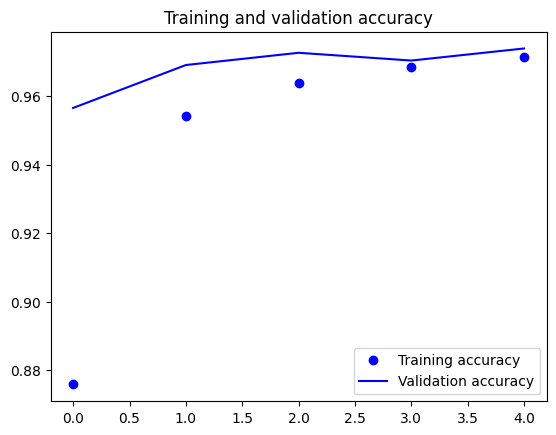

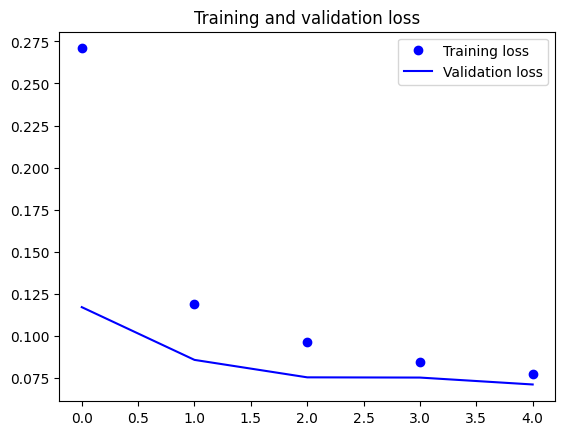

In [ ]:
evaluate_model(model_I)

In [ ]:
test_eval = model_I.evaluate(test_iterator, verbose=0)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.09205079078674316
Test accuracy: 0.9654343128204346


In [ ]:
# Save model
dump(model_I, 'model_I.joblib')
model_I.save('model_I.h5')
test_acc.append(test_eval[1])
test_loss.append(test_eval[0])
train_params.append(count_params(model_I.trainable_weights))
non_train_params.append(count_params(model_I.non_trainable_weights))

In [ ]:
model_name.clear()
test_acc.clear()
test_loss.clear()
train_params.clear()
non_train_params.clear()


*   After 5 epochs, the model has reached the val_accuracy 0.9740 and train_accuracy 0.9715.

*   Loss is also on similar level which means that model works well for validation and train set - generalization.
*   For test set the accuracy is 0.9654.


*   Model is not overfitting nor underfitting.


*   In first epoch - there is the biggest difference in loss and accuracy between validation and test data.





# Model 2 (dropout)

In [ ]:
# Architecture (CNN with MaxPooling and Dropout)
model_II = Sequential()

model_II.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
model_II.add(MaxPooling2D(4, 4))
model_II.add(Dropout(0.1))

model_II.add(Conv2D(64, (3,3), activation='relu'))
model_II.add(MaxPooling2D(4, 4))
model_II.add(Dropout(0.1))

model_II.add(Conv2D(64, (3,3), activation='relu'))
model_II.add(MaxPooling2D(2, 2))
model_II.add(Dropout(0.1))

model_II.add(Flatten())
model_II.add(Dense(16, activation='relu'))
model_II.add(Dense(1, activation='sigmoid'))
model_II.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)         

In [ ]:
# Model compilation
model_II.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_II = model_II.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=512)

Epoch 1/5
318/318 [==============================] - 345s 1s/step - loss: 0.3443 - accuracy: 0.8356 - val_loss: 0.1265 - val_accuracy: 0.9516
Epoch 2/5
318/318 [==============================] - 318s 1s/step - loss: 0.1502 - accuracy: 0.9409 - val_loss: 0.0948 - val_accuracy: 0.9662
Epoch 3/5
318/318 [==============================] - 307s 964ms/step - loss: 0.1230 - accuracy: 0.9519 - val_loss: 0.0923 - val_accuracy: 0.9642
Epoch 4/5
318/318 [==============================] - 307s 965ms/step - loss: 0.1105 - accuracy: 0.9570 - val_loss: 0.0743 - val_accuracy: 0.9727
Epoch 5/5
318/318 [==============================] - 312s 983ms/step - loss: 0.1001 - accuracy: 0.9618 - val_loss: 0.0664 - val_accuracy: 0.9759


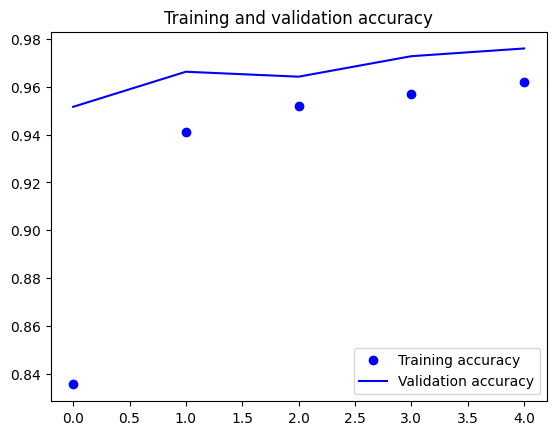

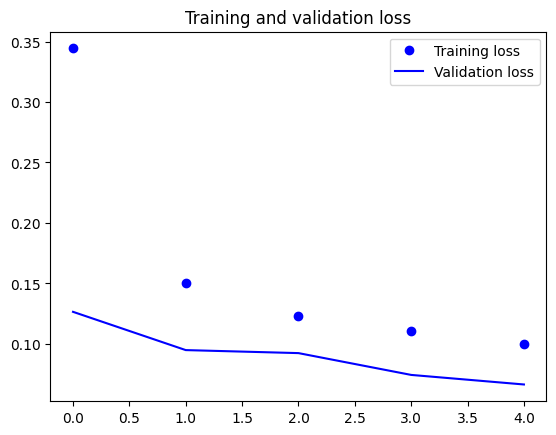

In [ ]:
evaluate_model(model_II)

In [ ]:
test_eval = model_II.evaluate(test_iterator, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.08632704615592957
Test accuracy: 0.966636598110199


In [ ]:
# Save model
dump(model_II, 'model_II.joblib')
model_II.save('model_II.h5')
test_acc.append(test_eval[1])
test_loss.append(test_eval[0])
train_params.append(count_params(model_II.trainable_weights))
non_train_params.append(count_params(model_II.non_trainable_weights))

* After 5 epochs, the model has reached the val_accuracy 0.9759 and train_accuracy 0.9618.
* Loss is also on similar level which means that model works well for validation and train set - generalization.
* For test set the accuracy is 0.9663.
* Model is not overfitting nor underfitting.
* In first epoch - there is the biggest difference in loss and accuracy between validation and test data.
* This tendency probably will be maintained in next epochs.

# Model 3 (normalization)

In [ ]:
# Architecture (CNN with MaxPooling, Dropout and normalization)
model_III = Sequential()

model_III.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
model_III.add(MaxPooling2D(4, 4))
model_III.add(BatchNormalization())
model_III.add(Dropout(0.1))

model_III.add(Conv2D(64, (3,3), activation='relu'))
model_III.add(MaxPooling2D(4, 4))
model_III.add(BatchNormalization())
model_III.add(Dropout(0.1))

model_III.add(Conv2D(64, (3,3), activation='relu'))
model_III.add(MaxPooling2D(2, 2))
model_III.add(BatchNormalization())
model_III.add(Dropout(0.1))

model_III.add(Flatten())
model_III.add(Dense(16, activation='relu'))
model_III.add(Dense(1, activation='sigmoid'))
model_III.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 32)       128       
 ormalization)                                                   
                                                                 
 dropout_3 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)        

In [ ]:
# Model compilation
model_III.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_III = model_III.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=512)

Epoch 1/5
318/318 [==============================] - 310s 964ms/step - loss: 0.1864 - accuracy: 0.9193 - val_loss: 0.4887 - val_accuracy: 0.7373
Epoch 2/5
318/318 [==============================] - 306s 961ms/step - loss: 0.1054 - accuracy: 0.9587 - val_loss: 0.0795 - val_accuracy: 0.9683
Epoch 3/5
318/318 [==============================] - 306s 963ms/step - loss: 0.0898 - accuracy: 0.9653 - val_loss: 0.0778 - val_accuracy: 0.9701
Epoch 4/5
318/318 [==============================] - 304s 957ms/step - loss: 0.0804 - accuracy: 0.9691 - val_loss: 0.0656 - val_accuracy: 0.9746
Epoch 5/5
318/318 [==============================] - 308s 970ms/step - loss: 0.0743 - accuracy: 0.9717 - val_loss: 0.0632 - val_accuracy: 0.9765


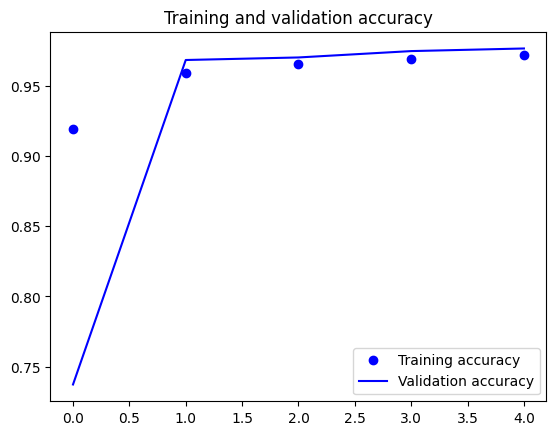

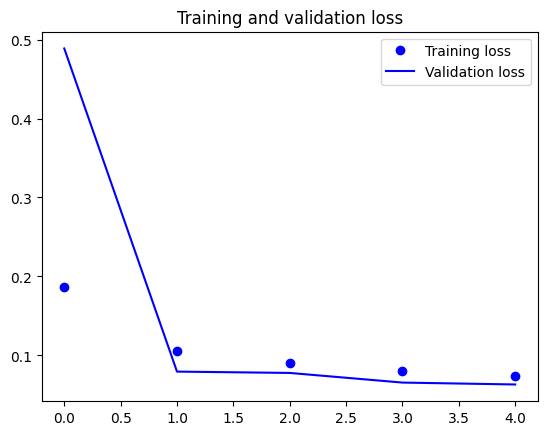

In [ ]:
evaluate_model(model_III)

In [ ]:
test_eval = model_III.evaluate(test_iterator, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.07873299717903137
Test accuracy: 0.9691914916038513


In [ ]:
# Save model
dump(model_III, 'model_III.joblib')
model_III.save('model_III.h5')
test_acc.append(test_eval[1])
test_loss.append(test_eval[0])
train_params.append(count_params(model_III.trainable_weights))
non_train_params.append(count_params(model_III.non_trainable_weights))

* After 5 epochs, the model has reached the val_accuracy 0.9765 and train_accuracy 0.9717.
* Loss is also on similar level which means that model works well for validation and train set - generalization.
* For test set the accuracy is 0.9691.
* Model is not overfitting nor underfitting.
* In first epoch - there is the biggest difference in loss and accuracy between validation and test data.
* This tendency probably will be maintained in next epochs.
* For third epoch train set had lower value for loss and higher for accuracy.

# Model 4

In [ ]:
# Architecture (CNN with MaxPooling, Dropout, regularization, initialization and normalization)
model_IV = Sequential()

model_IV.add(Conv2D(32, (5,5), kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), kernel_initializer='glorot_uniform', activation='relu', input_shape=(128,128,3)))
model_IV.add(MaxPooling2D(4, 4))
model_IV.add(BatchNormalization())
model_IV.add(Dropout(0.1))

model_IV.add(Conv2D(64, (3,3), kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), kernel_initializer='glorot_uniform', activation='relu'))
model_IV.add(MaxPooling2D(4, 4))
model_IV.add(BatchNormalization())
model_IV.add(Dropout(0.1))

model_IV.add(Conv2D(64, (3,3), kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), kernel_initializer='glorot_uniform', activation='relu'))
model_IV.add(MaxPooling2D(2, 2))
model_IV.add(BatchNormalization())
model_IV.add(Dropout(0.1))

model_IV.add(Flatten())
model_IV.add(Dense(16, activation='relu'))
model_IV.add(Dense(1, activation='sigmoid'))
model_IV.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 31, 31, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 64)        

In [ ]:
# Model compilation
model_IV.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_IV = model_IV.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=512)

Epoch 1/5
318/318 [==============================] - 313s 974ms/step - loss: 0.2376 - accuracy: 0.9119 - val_loss: 0.3776 - val_accuracy: 0.8433
Epoch 2/5
318/318 [==============================] - 310s 974ms/step - loss: 0.1428 - accuracy: 0.9561 - val_loss: 0.1270 - val_accuracy: 0.9627
Epoch 3/5
318/318 [==============================] - 310s 974ms/step - loss: 0.1246 - accuracy: 0.9635 - val_loss: 0.1180 - val_accuracy: 0.9649
Epoch 4/5
318/318 [==============================] - 306s 961ms/step - loss: 0.1134 - accuracy: 0.9678 - val_loss: 0.0955 - val_accuracy: 0.9744
Epoch 5/5
318/318 [==============================] - 307s 965ms/step - loss: 0.1069 - accuracy: 0.9704 - val_loss: 0.0872 - val_accuracy: 0.9765


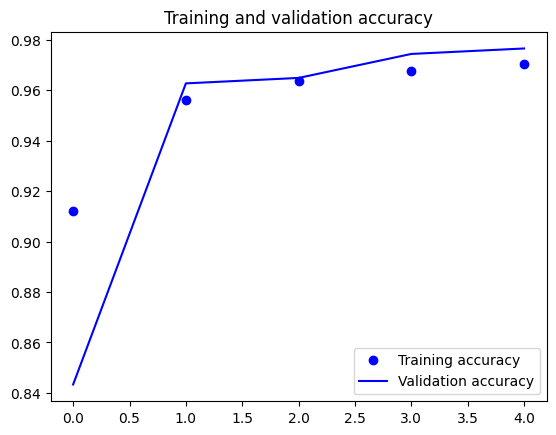

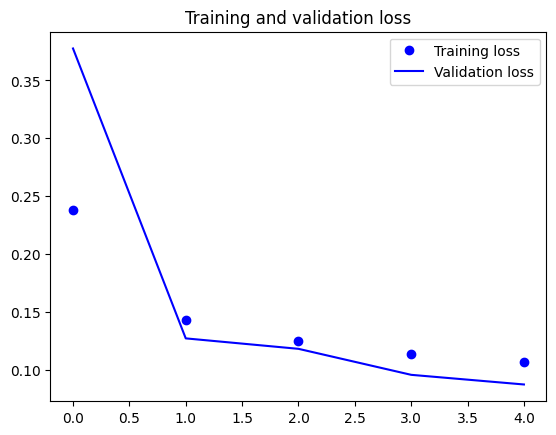

In [ ]:
evaluate_model(model_IV)

In [ ]:
test_eval = model_IV.evaluate(test_iterator, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.10171248018741608
Test accuracy: 0.9713455438613892


In [ ]:
# Save model
dump(model_IV, 'model_IV.joblib')
model_IV.save('model_IV.h5')
test_acc.append(test_eval[1])
test_loss.append(test_eval[0])
train_params.append(count_params(model_IV.trainable_weights))
non_train_params.append(count_params(model_IV.non_trainable_weights))

* After 5 epochs, the model has reached the same accuracy for val set 0.9765 an train set 0.9704.
* Loss is also on similar level which means that model works well for validation and train set - generalization.
* For test set the accuracy is 0.9713.
* Model is not overfitting nor underfitting.
* In first epoch - there is the biggest difference in loss and accuracy between validation and test data.
* This tendency probably will be maintained in next epochs.
* For second epoch train set had lower value for accuracy and higher for loss.

In [ ]:
summary = pd.DataFrame()
summary['Test loss'] = test_loss
summary['Test accuracy'] = test_acc
summary['Train params'] = train_params
summary['Non train params'] = non_train_params
summary

,Test loss,Test accuracy,Train params,Non train params
0,0.092051,0.965434,61985,0
1,0.086327,0.966637,61985,0
2,0.078733,0.969191,62305,320
3,0.101712,0.971346,62305,320


* The lowest test loss has reached by third model with normalization - 0.078733.
* The highest test accuracy has achieved by fourth model - 0.971346.

# **New image**

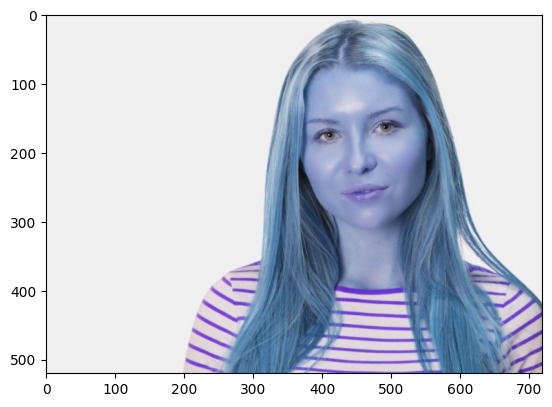

In [ ]:
# Image before transformations
# source: https://www.hairfinder.com/hair/longstraighthair2.jpg
img = '/content/new_img.jpg'
img = cv.imread(img)
plt.imshow(img)

In [ ]:
# Load image function
def load_img(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (128, 128, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [ ]:
# Load image
img = load_img('/content/new_img.jpg')

In [ ]:
# Prediction based on model 1
loaded_model = load('/content/model_I.joblib')
result = loaded_model.predict(img)
lab = result > 0.5
print(result[0])
print(lab[0])

1/1 [==============================] - 1s 591ms/step
[0.33313048]
[False]


In [ ]:
# Prediction based on model 2
loaded_model = load('/content/model_II.joblib')
result = loaded_model.predict(img)
lab = result > 0.5
print(result[0])
print(lab[0])

1/1 [==============================] - 0s 69ms/step
[0.3784913]
[False]


In [ ]:
# Prediction based on model 3
loaded_model = load('/content/model_III.joblib')
result = loaded_model.predict(img)
lab = result > 0.5
print(result[0])
print(lab[0])

1/1 [==============================] - 0s 95ms/step
[0.8917862]
[ True]


In [ ]:
# Prediction based on model 4
loaded_model = load('/content/model_IV.joblib')
result = loaded_model.predict(img)
lab = result > 0.5
print(result[0])
print(lab[0])

1/1 [==============================] - 0s 78ms/step
[0.10601461]
[False]


All models (except from Model 3) predict that there is a woman in the picture.